In [1]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

/home/srd/Desktop/music/venv_python3.7/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/srd/Desktop/music/venv_python3.7/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D,concatenate,Lambda,Bidirectional,GRU
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
import tensorflow.keras.callbacks

In [3]:
# For reproducibility purposes
np.random.seed(42)

# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [4]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [5]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
        hop_length=hop_length, n_mels=64)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    # np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))

In [6]:
def split_convert(X, y):
    arr_specs, arr_genres = [], []
    
    # Convert to spectrograms and split into small windows
    for fn, genre in zip(X, y):
        signal, sr = librosa.load(fn)
        signal = signal[:song_samples]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre)

        # Convert to "spec" representation
        specs = to_melspectrogram(signals)

        # Save files
        arr_genres.extend(y)
        arr_specs.extend(specs)
    
    return np.array(arr_specs), to_categorical(arr_genres)

In [7]:
def read_data(src_dir, genres, song_samples):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        for root, subdirs, files in os.walk(folder):
            for file in files:
                file_name = folder + "/" + file

                # Save the file name and the genre
                arr_fn.append(file_name)
                arr_genres.append(genres[x])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres, test_size=0.3, random_state=42, stratify=arr_genres
    )
    
    # Split into small segments and convert to spectrogram
    X_train, y_train = split_convert(X_train, y_train)
    X_test, y_test = split_convert(X_test, y_test)

    return X_train, X_test, y_train, y_test

In [8]:
# Parameters
gtzan_dir = '../data/genres/'
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

# Read the data
X_train, X_test, y_train, y_test = read_data(gtzan_dir, genres, song_samples)

In [49]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27300, 64, 65, 1) (11700, 64, 65, 1) (27300, 10) (11700, 10)


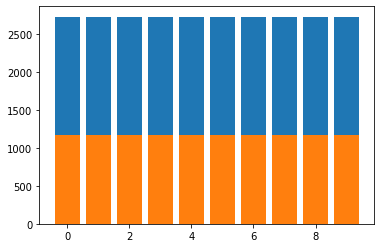

In [50]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

In [71]:
def conv_block(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.5)(x)
    return x

In [72]:
# Model Definition
def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    layer1=inpt#Input(shape=input_shape)
    x = conv_block(inpt, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    x = Flatten()(x)
    x = Dropout(0.5)(x)    
    pool_lstm1 = MaxPooling2D((2,2), name = 'pool_lstm',strides=(2,2))(layer1)
    squeezed = Lambda(lambda y: K.squeeze(y, axis= -1))(pool_lstm1)
    lstm = Bidirectional(GRU(256))(squeezed) 
    concat = concatenate([x, lstm], axis=-1, name ='concat')    
    x = Dense(128, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.05))(concat)
    x = Dropout(0.5)(x)
    predictions = Dense(num_genres,activation='softmax', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.05))(x)
    
    model = Model(inputs=inpt, outputs=predictions)
    return model

In [73]:
model = create_model(X_train[0].shape, 10)

In [74]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 65, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 62, 63, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 62, 63, 32)   0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 31, 31, 32)   0           activation_24[0][0]              
____________________________________________________________________________________________

### Loss function

In [75]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [76]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)

In [77]:

class WeightsSaver(tensorflow.keras.callbacks.Callback):
    def __init__(self, N):
        self.N = N
        self.batch = 0

    def on_epoch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            name = '../models/CNN_GRUweights%03d.h5' % self.batch
            self.model.save_weights(name)
        self.batch += 1

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(
                monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
hist = model.fit(X_train, y_train, batch_size=256, epochs=100,#EPOCH_COUNT,
                        validation_data=(X_test, y_test), verbose=1, callbacks=[reduce_lr,WeightsSaver(10)])


Train on 27300 samples, validate on 11700 samples
Epoch 1/100
27300/27300 [==============================] - 82s 3ms/sample - loss: 6.9099 - accuracy: 0.2789 - val_loss: 3.2273 - val_accuracy: 0.3412
Epoch 2/100
27300/27300 [==============================] - 79s 3ms/sample - loss: 2.4596 - accuracy: 0.4384 - val_loss: 2.1318 - val_accuracy: 0.4391
Epoch 3/100
27300/27300 [==============================] - 79s 3ms/sample - loss: 1.9066 - accuracy: 0.4836 - val_loss: 1.9080 - val_accuracy: 0.4442
Epoch 4/100
27300/27300 [==============================] - 88s 3ms/sample - loss: 1.7482 - accuracy: 0.5096 - val_loss: 1.8492 - val_accuracy: 0.4458
Epoch 5/100
27300/27300 [==============================] - 83s 3ms/sample - loss: 1.6701 - accuracy: 0.5272 - val_loss: 1.7919 - val_accuracy: 0.4738
Epoch 6/100
27300/27300 [==============================] - 85s 3ms/sample - loss: 1.6097 - accuracy: 0.5501 - val_loss: 1.7535 - val_accuracy: 0.4907
Epoch 7/100
27300/27300 [=========================

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

In [ ]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

## Majority Vote

In [24]:
def majority_vote(scores):
    values, counts = np.unique(scores,return_counts=True)
    ind = np.argmax(counts)
    return values[ind]

In [25]:
preds = model.predict(X_test, batch_size=128, verbose=0)

In [26]:
# Each sound was divided into 39 segments in our custom function
scores_songs = np.split(np.argmax(preds, axis=1), 300)
scores_songs = [majority_vote(scores) for scores in scores_songs]

In [27]:
# Same analysis for split
label = np.split(np.argmax(y_test, axis=1), 300)
label = [majority_vote(l) for l in label]

In [28]:
from sklearn.metrics import accuracy_score

print("majority voting system (acc) = {:.3f}".format(accuracy_score(label, scores_songs)))

majority voting system (acc) = 0.773


Compared to the classical approach, we are winning now!

We passed from a 78.8% accuracy to **82%**. It is not a great improvement but this is a really simple architecture.

## Save the model

In [31]:
# Save the model
model.save('../models/cnn_gru_final.h5')

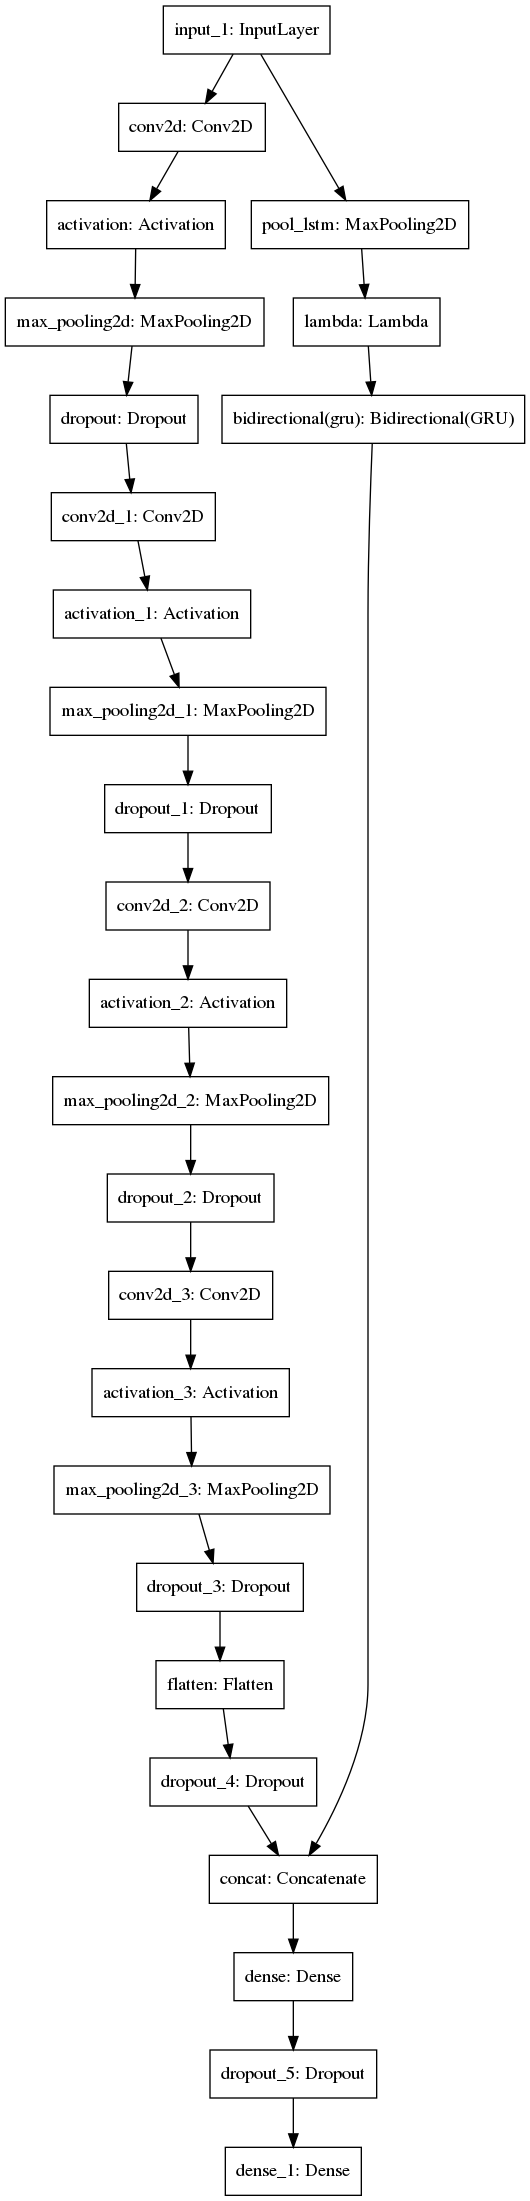

In [32]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_cnn_gru.png')